<a href="https://colab.research.google.com/github/hrishi508/Self-and-Semi-Supervised-Learning/blob/main/Pseudo_Labelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
# from torchviz import make_dot

import time
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive

Mounted at /content/drive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

## Data Preparation

Here, we are extracting 500 labelled images from the the training set for the self-supervised learning. Using labelled data sounds counter-intuitive but we are not using the labels in the training of the network, we are only using them for the TSNE visualization of the embedding vectors after every epoch.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),    
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),   
    
])

training_data = datasets.STL10(
    root="data",
    split="train",
    transform=transform,
    download=False
)

test_data = datasets.STL10(
    root="data",
    split='test',
    transform=transform,
    download=False
)

unlabelled = datasets.STL10(
    root="data",
    split="unlabeled",
    transform=transform,
    download=False
)

In [70]:
unlabeled_20000, _ = torch.utils.data.random_split(unlabelled, [20000, 80000])

In [ ]:
def imshow(imgt):
    img = imgt.clone()
    t1 = torch.tensor([0.485, 0.456, 0.406])
    t2 = torch.tensor([0.229, 0.224, 0.225])
    img[0]*=t2[0]
    img[1]*=t2[1]
    img[2]*=t2[2]

    img[0]+=t1[0]
    img[1]+=t1[1]
    img[2]+=t1[2]

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

monkey
torch.Size([3, 96, 96])


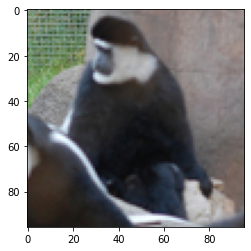

In [ ]:
labels_map = {
    0: "airplane",
    1: "bird",
    2: "car",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "horse",
    7: "monkey",
    8: "ship",
    9: "truck",
}
img, label = training_data[155]
print(labels_map[label])
print(img.shape)
imshow(img)

In [ ]:
## HYPERPARAMETERS
BATCH_SIZE = 64  #64
LR = 0.001      #0.001
EPOCHS = 100

labeled_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
unlabeled_dataloader = DataLoader(unlabeled_20000, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
# tf = train_features.unsqueeze(0)
# print(tf.shape)
# print(train_labels)
img = train_features[0]
imshow(img)

# Train and Test functions

In [98]:
T1 = 100
T2 = 300
af = 3

In [35]:
def alpha_weight(step):
    if step < T1:
        return 0.0
    elif step > T2:
        return af
    else:
         return ((step-T1) / (T2-T1))*af

In [110]:
def test(model):
  corrects = 0
  total = 0

  for X,y in test_dataloader:
      X = X.to(device)
      y = y.to(device)
      y_pred = model(X)
      _, predicted = torch.max(y_pred.data, 1)
      total += y.size(0)
      corrects += (predicted == y).sum().item()

  print(f"Accuracy of the model : {(float(corrects)/total)*100}%")

In [111]:
def semisup_train(model, train_dataloader, unlabeled_loader, criterion, optimizer, num_epochs=100):
    
    # Instead of using current epoch we use a "step" variable to calculate alpha_weight
    # This helps the model converge faster
    step = 100 
    model.to(device)
    model.train()
    for epoch in tqdm_notebook(range(num_epochs)):
        loss = 0
        for batch_idx, x_unlabeled in enumerate(unlabeled_loader):
            
            
            # Forward Pass to get the pseudo labels
            x_unlabeled, _ = x_unlabeled
            x_unlabeled = x_unlabeled.to(device)
            model.eval()
            output_unlabeled = model(x_unlabeled)
            _, pseudo_labeled = torch.max(output_unlabeled, 1)
            model.train()          
           
            # Now calculate the unlabeled loss using the pseudo label
            output = model(x_unlabeled)
            unlabeled_loss = alpha_weight(step) * criterion(output, pseudo_labeled)   
            loss += unlabeled_loss
            # Backpropogate
            optimizer.zero_grad()
            unlabeled_loss.backward()
            optimizer.step()
            
            
            # For every 50 batches train one epoch on labeled data 
            if batch_idx % 50 == 0:
                
                # Normal training procedure
                for batch_idx, (X_batch, y_batch) in enumerate(train_dataloader):
                    X_batch = X_batch.to(device)
                    y_batch = y_batch.to(device)
                    output = model(X_batch)
                    labeled_loss = criterion(output, y_batch)
                    loss += labeled_loss

                    optimizer.zero_grad()
                    labeled_loss.backward()
                    optimizer.step()
                
                # Now we increment step by 1
                step += 1
        torch.save(model_ft.state_dict(), '/content/drive/MyDrive/data/weights_stl10_semi_supervised_1.pth')
        
        print(f"Epoch {epoch} loss : {loss}")
        test(model)

# ResNet 9 Model

In [121]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNet9, self).__init__()
        
        self.conv1 = conv_block(in_channels, 64,pool=True)
        self.conv2 = conv_block(64, 128, pool=True) # output: 128 x 24 x 24
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True) # output: 256 x 12 x 12
        self.conv4 = conv_block(256, 512, pool=True) # output: 512 x 6 x 6
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [122]:
model_ft = ResNet9(3, 10)
# print(model_ft)
optimizer = torch.optim.Adam(params=model_ft.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

In [124]:
model_ft.load_state_dict(torch.load("/content/drive/MyDrive/weights_stl10.pth"))

<All keys matched successfully>

# Training

In [ ]:
semisup_train(model_ft, labeled_dataloader, unlabeled_dataloader, loss_fn, optimizer, num_epochs=60)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/60 [00:00<?, ?it/s]

In [107]:
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/data/weights_stl10_semi_supervised_final.pth')